In [1]:
import django, sys, os
sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

import math
from scoping.models import *
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from itertools import product, combinations
from utils.text import *
from scipy.sparse import find
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

from MulticoreTSNE import MulticoreTSNE as mTSNE
from sklearn.metrics import accuracy_score, precision_score, recall_score

p = Project.objects.get(pk=178)

In [2]:

def mash_texts(x, pat=None):
    s = ""
    for at in ["de", "kwp","ab", "ti",]:
        if hasattr(x.wosarticle, at) and getattr(x.wosarticle, at):
            t = getattr(x.wosarticle, at)
            if pat:
                t = re.sub(pat, "", t)
            s+=f" {t}"
    return s.strip()

In [3]:
docs = Doc.objects.filter(query=6956, content__iregex="\w").order_by('id')

## WHY IS OLIVEIRA, 2007 included?
### Also, Nepstad and Stickler, 2008
### Polidoro 2010, very weak - not main conclusion

# Exclude non-climate docs
docs = docs.exclude(pk__in=[
    
    # ENSO
    1461495, # Espinoza 2013
    1626875, # White, 2007
    
    1622783, # Why is Oliveira, 2007 included?
    1627593, # Killeen 2008
    1627701, # Also, Nepstad and Stickler, 2008
    2093363, # Etter
    2090005, # Nepstad, 2006
    1627734, # Polidoro 2010
    
    2089982, # Mars, 2007
    
    2090013, # Randolph 2010
    
    2093360, # Petney 2012
    
    2089960, # Wassenaar, 2007 - LUC
    1627733, # Polidoro 2010, very weak - not main conclusion
    2090004, # Veran 2007 - long line fishing
    2089967, # Giri - mangrove database, climate only mentioned in conclusion and with reference
    2089944, # Jellyman - eels
    2091676, # Novelo-Casanova, 2010: Cayman Islands climate??
    2089959, # Bruno, 2007 
    1514856, # de Waroux 2012
    2091680, # Guzman, 2008, we consider the main anthropogenic threats to the coral reefs and communities of the islands are overfishing, sedimentation and tourism
    2089950, # Razumov - permafrost and erosion - climate? is the ref there as counter-evidence Nevertheless, the longterm average annual rate
#                             of erosion of the coast line of the bottom of the Arctic
#                             Seas is much lower than in the seas outside the cry
#                             olithozone even under the conditions of the climate’s
#                             warming accompanied by the activation of thermo
#                             abrasion and during the subaqual abrasion processes
#                             (Fig. 5). In particular, this proves the development of
#                             ordinary abrasionaccumulation processes in the Arc
#                             tic Seas, and, here, we cannot say about the influence
#                             of thermal slumps on the formation of the underwater
#                             slope relief
])

#


docs.count()

257

In [4]:
cats = Category.objects.filter(project=p)
cats

<QuerySet [<Category: Mountains, snow and ice>, <Category: Rivers lakes and moisture>, <Category: Terrestrial ES>, <Category: Oceans and Coasts>, <Category: Human and managed>, <Category: not included in table>]>

In [5]:
ldf = pd.DataFrame.from_dict(list(docs.values('id','category__name')))
ldf['v'] = 1
cat_map = ldf.pivot_table(index="id", columns="category__name", values="v").fillna(0).reset_index()
cat_map.head()

category__name,id,Human and managed,"Mountains, snow and ice",Oceans and Coasts,Rivers lakes and moisture,Terrestrial ES
0,1599,0.0,0.0,0.0,0.0,1.0
1,2270,0.0,0.0,1.0,0.0,0.0
2,5570,0.0,0.0,1.0,0.0,0.0
3,11461,0.0,0.0,0.0,1.0,0.0
4,13585,0.0,0.0,0.0,0.0,1.0


In [6]:
doc_df = pd.DataFrame.from_dict(list(docs.values("id","title","content")))
print(doc_df.shape)
doc_df = pd.merge(doc_df, cat_map)
print(doc_df.shape)
doc_df.head()

cat_labels = [c for c in cats.values_list('name',flat=True) if c in doc_df.columns]


(257, 3)
(257, 8)


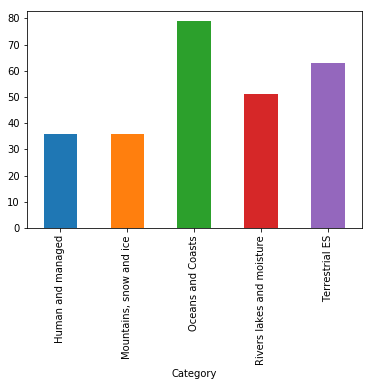

In [7]:
ldf.groupby('category__name')['v'].sum().plot.bar()

plt.xlabel("Category")
plt.savefig('../plots/category_distribution.png', bbox_inches="tight")

In [8]:
vec = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=5, max_df=0.9, strip_accents='unicode', 
    max_features=10000,
    tokenizer=snowball_stemmer()
)


texts = [mash_texts(x) for x in docs]
X = X = vec.fit_transform(texts)
vocab = vec.get_feature_names()

y = np.matrix(doc_df[cat_labels])

X

<257x2108 sparse matrix of type '<class 'numpy.float64'>'
	with 33731 stored elements in Compressed Sparse Row format>

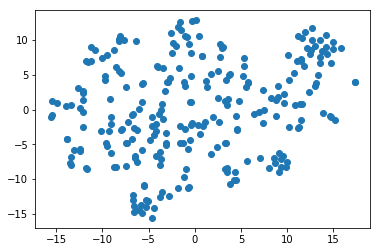

In [9]:
tsne = mTSNE(n_components=2, verbose=0, n_jobs=4)
tsne_results = tsne.fit_transform(X.toarray())


plt.scatter(tsne_results[:,0],tsne_results[:,1])

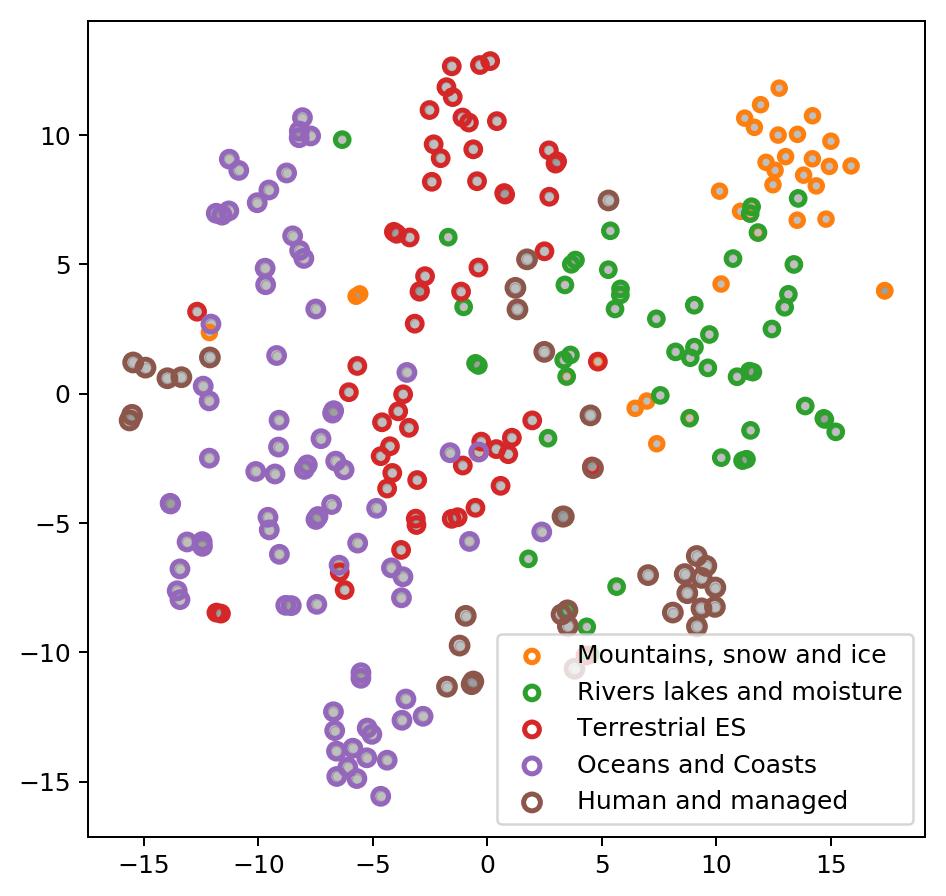

In [10]:
cat_labels = [c for c in cats.values_list('name',flat=True) if c in doc_df.columns]

fig, ax = plt.subplots(figsize=(6,6), dpi=180)

s = 20
ax.scatter(
    tsne_results[:,0], tsne_results[:,1],
    s=s, c="grey", alpha=0.5
)

for i,c in enumerate(cat_labels):
    ids = doc_df[doc_df[c]==1].index
    s+=5
    ax.scatter(
        tsne_results[ids,0], tsne_results[ids,1],
        edgecolors=f"C{i+1}",
        lw=2,
        c="None",
        s=s,
        label=c
    )
    
ax.legend()

In [11]:
clf = OneVsRestClassifier(SVC(kernel='linear'))

k = math.ceil(len(doc_df.index)*0.7)

train_index = pd.Index(random.sample(list(doc_df.index),k))

test_index = pd.Index([x for x in doc_df.index if x not in train_index])

clf.fit(X[train_index],y[train_index])
y_pred = clf.predict(X[test_index])
accuracy = accuracy_score(y[test_index], y_pred)

print(accuracy)

predictions_df = pd.DataFrame(y_pred)
predictions_df.index = test_index
predictions_df.columns = cat_labels
predictions_df.head()

0.6753246753246753


,"Mountains, snow and ice",Rivers lakes and moisture,Terrestrial ES,Oceans and Coasts,Human and managed
2,0,0,0,0,0
4,0,0,1,0,0
7,0,0,1,0,0
8,0,0,1,0,0
12,0,0,0,0,0


Mountains, snow and ice: accuracy - 92.21%, precision - 81.82%, recall - 69.23%
Rivers lakes and moisture: accuracy - 89.61%, precision - 87.50%, recall - 50.00%
Terrestrial ES: accuracy - 92.21%, precision - 100.00%, recall - 72.73%
Oceans and Coasts: accuracy - 96.10%, precision - 95.00%, recall - 90.48%
Human and managed: accuracy - 90.91%, precision - 100.00%, recall - 30.00%


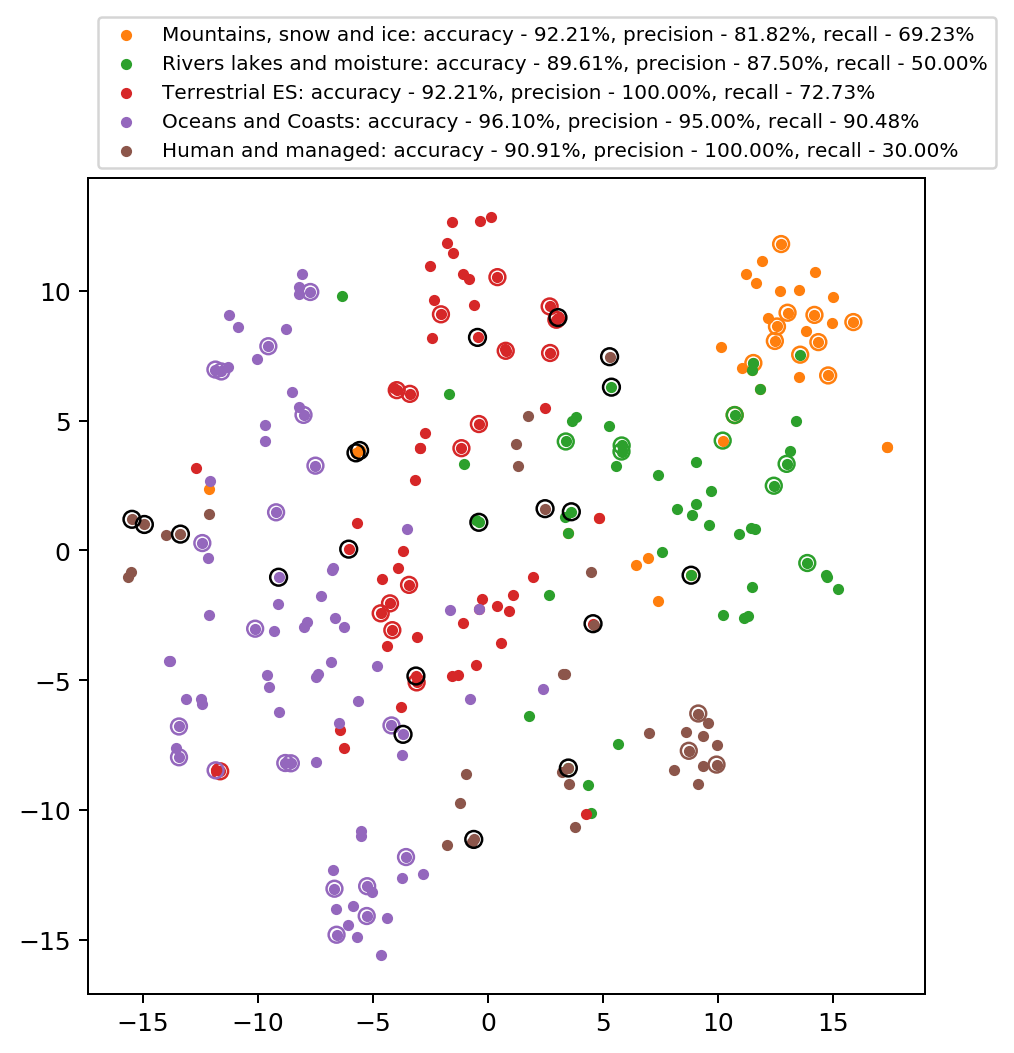

In [13]:
cat_labels = [c for c in cats.values_list('name',flat=True) if c in doc_df.columns]

fig, ax = plt.subplots(figsize=(6,6), dpi=180)

s = 20

for i,c in enumerate(cat_labels):
    ids = doc_df[doc_df[c]==1].index
    
    pred_y = predictions_df[c]
    c_acc = accuracy_score(y[test_index,i],pred_y)
    c_p = precision_score(y[test_index,i],pred_y)
    c_r = recall_score(y[test_index,i],pred_y)
    l = f"{c}: accuracy - {c_acc:.2%}, precision - {c_p:.2%}, recall - {c_r:.2%}"
    
    ax.scatter(
        tsne_results[ids,0], tsne_results[ids,1],
        edgecolors=f"C{i+1}",
        lw=0,
        c=f"C{i+1}",
        s=s,
        label=l
    )
    
    pred_y = predictions_df[c]
    c_acc = accuracy_score(y[test_index,i],pred_y)
    c_p = precision_score(y[test_index,i],pred_y)
    c_r = recall_score(y[test_index,i],pred_y)
    print(f"{c}: accuracy - {c_acc:.2%}, precision - {c_p:.2%}, recall - {c_r:.2%}")
    
    ids = predictions_df[predictions_df[c]==1].index

    ax.scatter(
        tsne_results[ids,0], tsne_results[ids,1],
        edgecolors=f"C{i+1}",
        lw=1,
        c="None",
        s=s+20,
    )
    
ids = predictions_df.sum(axis=1)[predictions_df.sum(axis=1)==0].index
ax.scatter(
    tsne_results[ids,0], tsne_results[ids,1],
    edgecolors="black",
    lw=1,
    c="None",
    s=s+25,
)
    
ax.legend(loc="lower left", bbox_to_anchor=(0,1), fontsize=8)

plt.savefig("../plots/original_predictions.png", bbox_inches="tight")